In [75]:
from google.cloud import bigquery

import os
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import hot
import seaborn as sns
from datetime import datetime
import math
from math import sqrt
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.externals import joblib
import tensorflow as tf
from scipy import stats
import xgboost as xgb
from functools import partial
import itertools
from bokeh.models import BoxZoomTool
from bokeh.plotting import figure, output_notebook, show
output_notebook()
import datashader as ds
from datashader.utils import export_image
from datashader import transfer_functions as transfer_functions
%matplotlib inline

Loading BokehJS ...

## Featuer Engineering using BigQuery and import data

In [76]:
# Access Big Query
client = bigquery.Client()

In [135]:
# Pull data and feature engineering 
# The training data set will include 1M rows
# Feature engineering to generate new columns: 
#Year, Date, Hour, Weekday of the trip, whether the trip starts or end in an airport, duration of the trip in minutes.

sql="""
with tmp_tb as (
SELECT
    unique_key, 
    taxi_id, 
    DATETIME(trip_start_timestamp, 'America/Chicago') trip_start_timestamp, 
    DATETIME(trip_end_timestamp, 'America/Chicago') trip_end_timestamp, 
    trip_miles, 
    pickup_census_tract, 
    dropoff_census_tract, 
    pickup_community_area, 
    dropoff_community_area, 
    payment_type, 
    company, 
    pickup_latitude, 
    pickup_longitude, 
    dropoff_latitude, 
    dropoff_longitude,
    fare fare_dollars
FROM
    `bigquery-public-data.chicago_taxi_trips.taxi_trips` 
WHERE 
    fare > 0 and fare is not null and trip_miles > 0 and trip_miles is not null
ORDER BY 
    RAND()
LIMIT 1000000)
SELECT *, 
    CAST(trip_start_timestamp AS DATE) trip_start_dt,
    CAST(trip_end_timestamp AS DATE) trip_end_dt,
    DATETIME_DIFF(trip_end_timestamp, trip_start_timestamp, MINUTE) trip_minutes,
    EXTRACT(YEAR FROM trip_start_timestamp) year,
    EXTRACT(MONTH FROM trip_start_timestamp) month,
    EXTRACT(DAY FROM trip_start_timestamp) day,
    EXTRACT(HOUR FROM trip_start_timestamp) hour,
    FORMAT_DATE('%a', DATE(trip_start_timestamp)) weekday,
    CASE WHEN (pickup_community_area IN (56, 64, 76)) OR (dropoff_community_area IN (56, 64, 76)) THEN 1 else 0 END is_airport
FROM tmp_tb
"""

df = client.query(sql).to_dataframe()
df.head()

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,payment_type,...,fare_dollars,trip_start_dt,trip_end_dt,trip_minutes,year,month,day,hour,weekday,is_airport
0,9afd35ec817bdbf963b4986f59f5ed3cbff0b8c4,417500d2bdac7a8c104b98016c9518146be264963d7956...,2013-04-15 19:30:00,2013-04-15 19:45:00,0.10,NaN,NaN,NaN,NaN,Credit Card,...,29.65,2013-04-15,2013-04-15,15,2013,4,15,19,Mon,0
1,d3cbc3df15485312b6070db1e74f32ce71e19981,27be917c0b50e9877ac4e23156d4d12d399481db7e0e9f...,2017-11-27 15:30:00,2017-11-27 15:45:00,17.33,1.703198e+10,1.703184e+10,76.0,32.0,Credit Card,...,42.50,2017-11-27,2017-11-27,15,2017,11,27,15,Mon,1
2,2dc2bb860bbe0c5ada7d6c690c6302b72913c9a5,1894f6935f54bc786fb24b8c07705e8714f62fa301176d...,2019-02-11 10:45:00,2019-02-11 11:00:00,0.70,1.703184e+10,1.703184e+10,32.0,32.0,Credit Card,...,5.25,2019-02-11,2019-02-11,15,2019,2,11,10,Mon,0
3,65c0386a3872747d7b3b0606da84f302e7c5b445,4d81d7364e7e4fb7517fe1d8a072d1a4be0eeb400cd653...,2013-02-28 12:45:00,2013-02-28 13:00:00,6.10,NaN,NaN,32.0,7.0,Credit Card,...,16.05,2013-02-28,2013-02-28,15,2013,2,28,12,Thu,0
4,2004d411384db2c6dd25bbb2425bd8edf01c9e0e,a71b3ca5eaf2530647c68518a8c8dba369222a4c1071eb...,2014-12-22 07:30:00,2014-12-22 07:45:00,5.30,NaN,NaN,NaN,NaN,Cash,...,14.25,2014-12-22,2014-12-22,15,2014,12,22,7,Mon,0


In [136]:
df.dtypes

unique_key                        object
taxi_id                           object
trip_start_timestamp      datetime64[ns]
trip_end_timestamp        datetime64[ns]
trip_miles                       float64
pickup_census_tract              float64
dropoff_census_tract             float64
pickup_community_area            float64
dropoff_community_area           float64
payment_type                      object
company                           object
pickup_latitude                  float64
pickup_longitude                 float64
dropoff_latitude                 float64
dropoff_longitude                float64
fare_dollars                     float64
trip_start_dt                     object
trip_end_dt                       object
trip_minutes                       int64
year                               int64
month                              int64
day                                int64
hour                               int64
weekday                           object
is_airport      

In [140]:
df.describe()

,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,fare_dollars,trip_minutes,year,month,day,hour,is_airport
count,1000000.000000,6.798690e+05,6.760810e+05,914123.000000,894101.000000,914160.000000,914160.000000,896733.000000,896733.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,4.112414,1.703137e+10,1.703136e+10,23.549243,21.646902,41.901710,-87.659984,41.901639,-87.654919,13.347827,14.690895,2015.607352,6.422836,15.652172,11.083394,0.126167
std,12.700018,3.434554e+05,3.332072e+05,19.963792,17.874398,0.038521,0.073257,0.038617,0.059876,31.573742,705.770612,1.670464,3.393848,8.685107,5.632362,0.332038
min,0.010000,1.703101e+10,1.703101e+10,1.000000,1.000000,41.660136,-87.913625,41.660136,-87.913625,0.010000,-310605.000000,2012.000000,1.000000,1.000000,0.000000,0.000000
25%,0.900000,1.703108e+10,1.703108e+10,8.000000,8.000000,41.880994,-87.655998,41.880994,-87.655998,6.250000,0.000000,2014.000000,3.000000,8.000000,7.000000,0.000000
50%,1.600000,1.703128e+10,1.703128e+10,24.000000,21.000000,41.892508,-87.632746,41.892508,-87.633308,8.500000,15.000000,2016.000000,6.000000,16.000000,11.000000,0.000000
75%,4.000000,1.703184e+10,1.703183e+10,32.000000,32.000000,41.914616,-87.626211,41.921778,-87.626211,14.000000,15.000000,2017.000000,9.000000,23.000000,15.000000,0.000000
max,2090.000000,1.703198e+10,1.703198e+10,77.000000,77.000000,42.016046,-87.534903,42.021224,-87.534903,9000.760000,595065.000000,2019.000000,12.000000,31.000000,23.000000,1.000000


In [141]:
# missing values
print(df.isnull().sum())

unique_key                     0
taxi_id                        0
trip_start_timestamp           0
trip_end_timestamp             0
trip_miles                     0
pickup_census_tract       320131
dropoff_census_tract      323919
pickup_community_area      85877
dropoff_community_area    105899
payment_type                   0
company                   230354
pickup_latitude            85840
pickup_longitude           85840
dropoff_latitude          103267
dropoff_longitude         103267
fare_dollars                   0
trip_start_dt                  0
trip_end_dt                    0
trip_minutes                   0
year                           0
month                          0
day                            0
hour                           0
weekday                        0
is_airport                     0
dtype: int64


In [142]:
# make a copy of the original data
df_2 = df.copy()

# Data Exploration

## Check how many rides are share rides. Include only non-shared rides

In [146]:
# If two unique_key have the same taxi_id and trip_start_timestamp, it is considered a shared ride

aggregations = {
    'unique_key':{
        'passengers': 'count'
    },
    'fare_dollars':{
        'max_fare': 'max', 
        'min_fare': 'min'
    }   
}

df_share_rides = df_2[['unique_key', 'taxi_id', 'trip_start_timestamp', 'fare_dollars']].groupby(['taxi_id', 'trip_start_timestamp']).agg(aggregations)
df_share_rides.columns = df_share_rides.columns.get_level_values(1)
df_share_rides.head()

/usr/local/lib/python3.5/dist-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


passengers  \
taxi_id                                            trip_start_timestamp               
0004366432bcef5a9526884fdec76bca727b29345266e73... 2016-01-03 08:45:00            1   
                                                   2016-01-08 06:00:00            1   
0005e9157e3cfe52948317ab2089170ad4c25cb8f7ead52... 2016-11-22 06:00:00            1   
                                                   2017-03-19 09:00:00            1   
                                                   2017-03-20 12:45:00            1   

                                                                         min_fare  \
taxi_id                                            trip_start_timestamp             
0004366432bcef5a9526884fdec76bca727b29345266e73... 2016-01-03 08:45:00       0.01   
                                                   2016-01-08 06:00:00       0.01   
0005e9157e3cfe52948317ab2089170ad4c25cb8f7ead52... 2016-11-22 06:00:00       9.80   
                                                   2017-03-19 09:00:00       5.40   
                                                   2017-03-20 12:45:00      16.40   

                                                                         max_fare  
taxi_id                                            trip_start_timestamp            
0004366432bcef5a9526884fdec76bca727b29345266e73... 2016-01-03 08:45:00       0.01  
                                                   2016-01-08 06:00:00       0.01  
0005e9157e3cfe52948317ab2089170ad4c25cb8f7ead52... 2016-11-22 06:00:00       9.80  
                                                   2017-03-19 09:00:00       5.40  
                                                   2017-03-20 12:45:00      16.40

In [149]:
# Filter to include only the rides that are not share rides
# For modeling purposes, only include the ones that are not share rides, to get an accurate estimation of the fare

df_3 = df_2.merge(df_share_rides, left_on=['taxi_id', 'trip_start_timestamp'], right_on=['taxi_id', 'trip_start_timestamp'], how='left')
df_4 = df_3.loc[df_3.passengers == 1]
df_4.shape

(998645, 28)

## Explore the distribution of fare

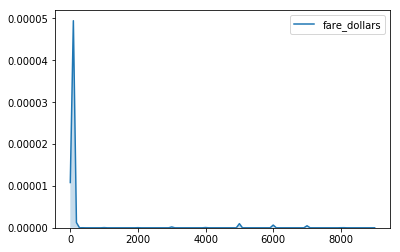

In [150]:
# plot the distribution of fare
sns.kdeplot(df_4.fare_dollars, shade=True)

### Most of the fare were under $2000 per trip. There are a few big numbers, which needs further explorations on if they are legit fare prices or bad data.

## Exploring relationship between fare, rides, duration of rides over time

In [152]:
df_4['mmdd'] = df_4.trip_start_timestamp.map(lambda x: x.strftime('%m-%d'))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Number of Rides by Pickup Hour')

<Figure size 432x288 with 0 Axes>

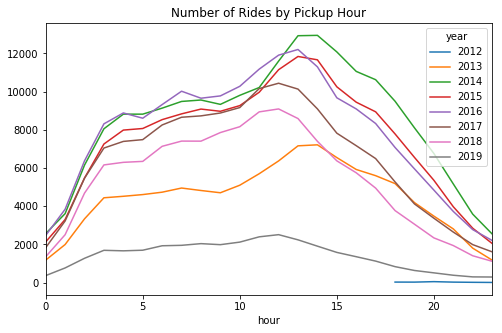

In [153]:
fig = plt.figure()
ax1 = df_4.pivot_table('unique_key', index='hour', columns='year', aggfunc=lambda x: len(x.unique())).plot(figsize=(8,5))
plt.title('Number of Rides by Pickup Hour')

Text(0.5, 1.0, 'Average Fare($) per Ride by Pickup Time')

<Figure size 432x288 with 0 Axes>

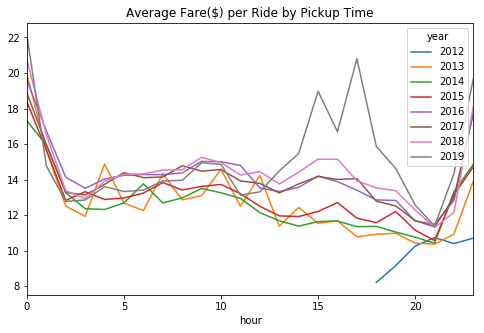

In [154]:
fig = plt.figure()
ax1 = df_4.pivot_table('fare_dollars', index='hour', columns='year').plot(figsize=(8, 5))
plt.title('Average Fare($) per Ride by Pickup Time')

Text(0.5, 1.0, 'Average Fare($) per Ride by Pickup Time')

<Figure size 432x288 with 0 Axes>

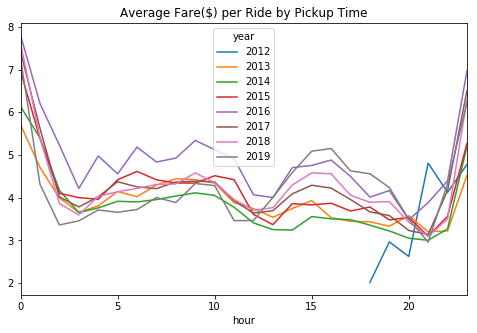

In [155]:
fig = plt.figure()
ax1 = df_4.pivot_table('trip_miles', index='hour', columns='year').plot(figsize=(8, 5))
plt.title('Average Fare($) per Ride by Pickup Time')

Text(0.5, 1.0, 'Number of Rides by Day')

<Figure size 432x288 with 0 Axes>

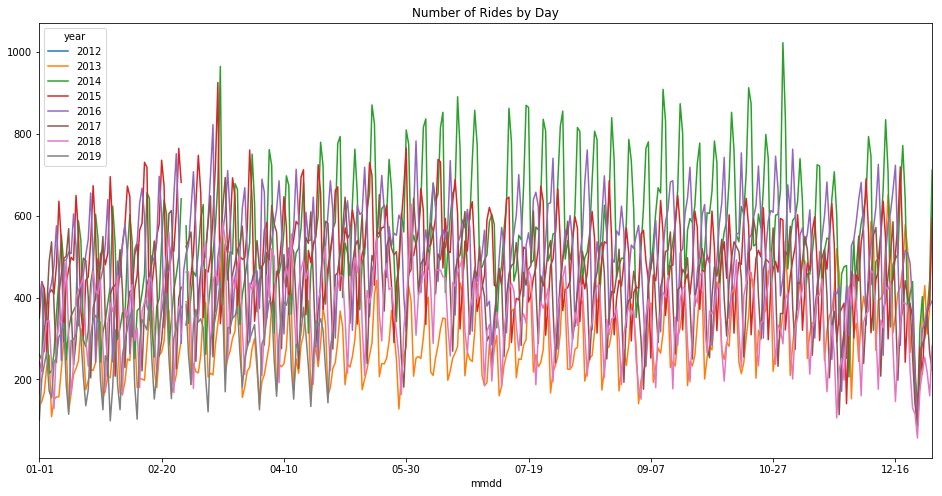

In [156]:
fig = plt.figure()
ax1 = df_4.pivot_table('unique_key', index='mmdd', columns='year', aggfunc=lambda x: len(x.unique())).plot(figsize=(16,8))
plt.title('Number of Rides by Day')

In [158]:
tmp_pivot = df_4.loc[df_4.year == 2014].pivot_table('unique_key', index='mmdd', aggfunc=lambda x: len(x.unique()))
tmp_pivot.unique_key.loc[tmp_pivot.unique_key == tmp_pivot.unique_key.max()]

# peak day is 3-15, St Patrick's Day

mmdd
10-31    1022
Name: unique_key, dtype: int64

From the above, it seems that during peak hours, there are more rides, but the rides are shorter and the fares are lower. Day of the year also impacts the number of rides.

## Explores the locations of the rides

In [159]:
# This function plots the rides on a map of chicago
def plot_data_points(longitude, latitude, data_frame, focus_point) :
    cvs = ds.Canvas(plot_width=500, plot_height=400)
    export  = partial(export_image, export_path = "export", background="black")
    agg = cvs.points(data_frame, longitude, latitude, ds.count())
    img = transfer_functions.shade(agg, cmap= hot, how='eq_hist')
    image_xpt  =  transfer_functions.dynspread(img, threshold=0.5, max_px=4)
    return export(image_xpt,"map")

/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


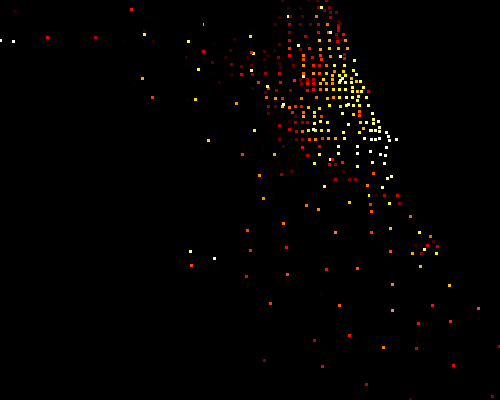

In [160]:
# pickup locations
plot_data_points('pickup_longitude', 'pickup_latitude', df_4, 'unique_key')

/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


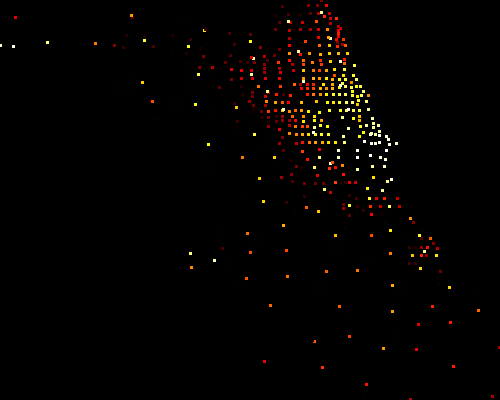

In [161]:
# plot of dropoff location
plot_data_points('dropoff_longitude', 'dropoff_latitude', df_4, 'unique_key')

## Explore relationships between trip duration, trip length and fares

Text(0, 0.5, 'Fare($)')

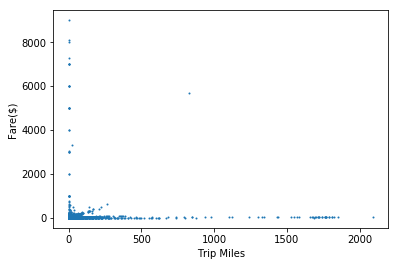

In [162]:
plt.scatter(df_4.trip_miles, df_4.fare_dollars, s = 1)
plt.xlabel('Trip Miles')
plt.ylabel('Fare($)')

It seems that there are a few rides with a much longer trip miles and fare amount. The following plot will zoom in to the trip with 500 miles or less, and fare dollars below 300.

Text(0, 0.5, 'Fare($)')

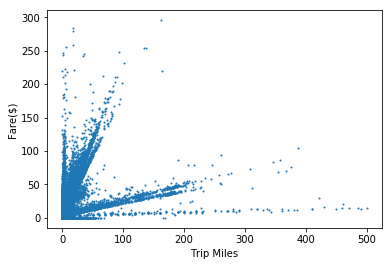

In [163]:
plt.scatter(df_4.trip_miles.loc[(df_4.trip_miles <=500) & (df_4.fare_dollars <=300)], 
            df_4.fare_dollars.loc[(df_4.trip_miles <=500) & (df_4.fare_dollars <=300)], 
            s = 1)
plt.xlabel('Trip Miles')
plt.ylabel('Fare($)')

### Check how many rides have are 500 miles or less, and cost $300 or less.

In [164]:
df_4.trip_miles.loc[(df_4.trip_miles <=500) & (df_4.fare_dollars <=300)].shape

(998528,)

### 99.7% of the trips were less than 500 miles and less than 300 dollars.

There are two main relationships between miles and fare. One seems to reflect the normal taxi rates. The other one seems to have a higher rate. The rides with higher rates are not related to whether it is a route to/from the airport, or downtown. The hypothesis is that those are premium services. 

Given this hypothesis, the next step is to identify which rides are premium services, and how to predict what type of service it is in the future, before knowing the fare.

In predicting whether a ride is a premium service, there are two hypothesis:
(1) a certain company mostly provides one type of service;
(2) a certain taxi_id always provides a premium or normal service.
It is also possible that a driver provides premium services when affiliated with a certain company, but might provide normal services when affiliated with another company.

The next steps is to explore which companies tend to provide premium services, and which drivers have provied premium services.

## Examine the trips provided by different companies

#### Two criteria are used when examining the trips by different companies:
#### (1) dollars per mile
#### (2) miles per trip

In [165]:
aggregations = {
    'unique_key':{
        'rides': 'count'
    },
    'fare_dollars':{
        'total_fare': 'sum'    
    },
    'trip_miles':{
        'total_miles': 'sum'
    }
}

by_company = df_4.groupby('company').agg(aggregations)
by_company.columns = by_company.columns.get_level_values(1)
by_company['miles_per_trip'] = by_company.total_miles/by_company.rides
by_company['dollars_per_mile'] = by_company.total_fare/by_company.total_miles

/usr/local/lib/python3.5/dist-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


### companies that charge the highest dollars per mile

In [166]:
by_company.sort_values(['dollars_per_mile'], ascending = False).head()

,rides,total_fare,total_miles,miles_per_trip,dollars_per_mile
company,,,,,
2767 - Sayed M Badri,1,6.65,0.1,0.100000,66.500000
Blue Ribbon Taxi Association Inc.,15369,268387.96,8448.3,0.549697,31.768280
1408 - Donald Barnes,1,4.85,0.6,0.600000,8.083333
2809 - 95474 C&D Cab Co Inc.,1,6.25,1.1,1.100000,5.681818
585 - Valley Cab Co,7,49.75,9.0,1.285714,5.527778


In [167]:
#### It seems that Blue Ribbon Taxi Association Inc. mainly provides premium experience, at a large scale.
##### Create one column, is_luxury, to mark the company that provides premium experience.
df_4['is_luxury'] = np.where(df_4.company.isin(['Blue Ribbon Taxi Association Inc.', 'Suburban Dispatch LLC']), 1, 0)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Examine the trips provided by different taxi drivers

In [168]:
# Profiling the taxi_ids, showing miles_per_trip and dollars_per_mile for each taxi_id
aggregations = {
    'unique_key':{
        'rides': 'count'
    },
    'fare_dollars':{
        'total_fare': 'sum'    
    },
    'trip_miles':{
        'total_miles': 'sum'
    }
}

by_driver = df_4.groupby('taxi_id').agg(aggregations)
by_driver.columns = by_driver.columns.get_level_values(1)
by_driver['miles_per_trip'] = by_driver.total_miles/by_driver.rides
by_driver['dollars_per_mile'] = by_driver.total_fare/by_driver.total_miles
by_driver.sort_values(['dollars_per_mile'], ascending = False).head()

/usr/local/lib/python3.5/dist-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,rides,total_fare,total_miles,miles_per_trip,dollars_per_mile
taxi_id,,,,,
2c9e6892a16411ee7efb69f8b6dc4040e9b3347b4799eef5bf82b7892f4bbc2fd9bba898ea6296e9c51dda3e3e48f34adb94de91bfc13e423a6921b3abaad159,57,11479.89,110.2,1.933333,104.173230
b4918e3dc616260ba3c7c57ccf5345c43f853abd067d61aaa32e4ec344d44938260d4f7ef46913aa2a3ff556b05c32e3157899097fd68b8f732d88e3dd16d8dd,5,57.75,0.7,0.140000,82.500000
341d6e8bdcbbd41081743ae65c0b6cc962bb42c225971b6dc4c4fb6550e25643a5035e36fb0c135cd8fde8cbd93cdd44ee9db3ad1854325fe83c782e55334785,1,16.00,0.2,0.200000,80.000000
8e937c42425bbfba5e3b54fe3fd7ea60cc98d94ad9d837aa7a1183388786149de885c7f932855798d6d0d7ae522684d52ba3d60230ad82dbae58dc50012fd0f4,181,52556.86,740.8,4.092818,70.946085
768431d476300aa4759020069a99c25201a9ce1c21e94e0ddc7be63cee1fd4061abbb9a63d248e5cb264e9fd32b81300fa9658deed7e4c6d2b5df1489e123f12,15,206.00,3.0,0.200000,68.666667


## Use KMeans clustering to cluster the drivers into different groups.

In [169]:
# Standardize the data for clustering
by_driver_standard = stats.zscore(by_driver[['dollars_per_mile']])

### Two clusters

Text(0.5, 1.0, 'KMeans Results (k = 2)')

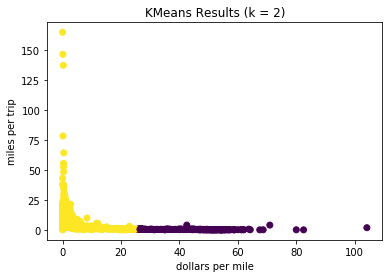

In [170]:
# KMeans clustering
k2 = KMeans(n_clusters = 2, random_state = 0).fit(by_driver_standard)
by_driver['k2'] = k2.labels_
by_driver.groupby(['k2']).mean()

# Plot the clustering results
plt.scatter(by_driver.dollars_per_mile, by_driver.miles_per_trip, c = -by_driver.k2)
plt.xlabel('dollars per mile')
plt.ylabel('miles per trip')
plt.title('KMeans Results (k = 2)')

### Three clusters

Text(0.5, 1.0, 'KMeans Results (k = 3)')

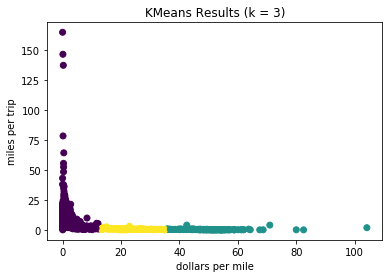

In [171]:
k3 = KMeans(n_clusters = 3, random_state = 0).fit(by_driver_standard)
by_driver['k3'] = k3.labels_
by_driver.groupby(['k3']).mean()

plt.scatter(by_driver.dollars_per_mile, by_driver.miles_per_trip, c = by_driver.k3)
plt.xlabel('dollars per mile')
plt.ylabel('miles per trip')
plt.title('KMeans Results (k = 3)')

### Four clusters

Text(0.5, 1.0, 'KMeans Results (k = 4)')

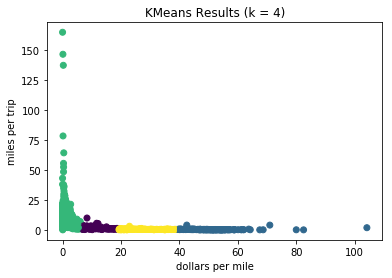

In [172]:
# try four clusters
k4 = KMeans(n_clusters = 4, random_state = 0).fit(by_driver_standard)
by_driver['k4'] = k4.labels_
by_driver.groupby(['k4']).mean()

plt.scatter(by_driver.dollars_per_mile, by_driver.miles_per_trip, c = by_driver.k4)
plt.xlabel('dollars per mile')
plt.ylabel('miles per trip')
plt.title('KMeans Results (k = 4)')

### Combine the KMeans Clustering results with the original data

In [173]:
df_5 = df_4.merge(by_driver, left_on=['taxi_id'], right_on='taxi_id', how='left')
df_5.head()

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,payment_type,...,mmdd,is_luxury,rides,total_fare,total_miles,miles_per_trip,dollars_per_mile,k2,k3,k4
0,9afd35ec817bdbf963b4986f59f5ed3cbff0b8c4,417500d2bdac7a8c104b98016c9518146be264963d7956...,2013-04-15 19:30:00,2013-04-15 19:45:00,0.10,NaN,NaN,NaN,NaN,Credit Card,...,04-15,0,177,2434.60,740.40,4.183051,3.288223,0,0,2
1,d3cbc3df15485312b6070db1e74f32ce71e19981,27be917c0b50e9877ac4e23156d4d12d399481db7e0e9f...,2017-11-27 15:30:00,2017-11-27 15:45:00,17.33,1.703198e+10,1.703184e+10,76.0,32.0,Credit Card,...,11-27,0,185,2438.36,778.39,4.207514,3.132569,0,0,2
2,2dc2bb860bbe0c5ada7d6c690c6302b72913c9a5,1894f6935f54bc786fb24b8c07705e8714f62fa301176d...,2019-02-11 10:45:00,2019-02-11 11:00:00,0.70,1.703184e+10,1.703184e+10,32.0,32.0,Credit Card,...,02-11,0,203,2355.50,511.25,2.518473,4.607335,0,0,2
3,65c0386a3872747d7b3b0606da84f302e7c5b445,4d81d7364e7e4fb7517fe1d8a072d1a4be0eeb400cd653...,2013-02-28 12:45:00,2013-02-28 13:00:00,6.10,NaN,NaN,32.0,7.0,Credit Card,...,02-28,0,154,2126.80,726.00,4.714286,2.929477,0,0,2
4,2004d411384db2c6dd25bbb2425bd8edf01c9e0e,a71b3ca5eaf2530647c68518a8c8dba369222a4c1071eb...,2014-12-22 07:30:00,2014-12-22 07:45:00,5.30,NaN,NaN,NaN,NaN,Cash,...,12-22,0,145,2240.26,808.90,5.578621,2.769514,0,0,2


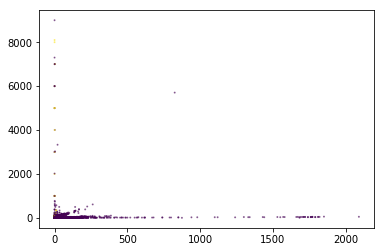

In [174]:
plt.scatter(df_5.trip_miles, df_5.fare_dollars, c = df_5.k2, s = 1, alpha = 0.5)
plt.show()

## Filter data for training

In [176]:
# the upper limit of acceptable fare: 4 sd 
fare_upper = df_5.describe().fare_dollars['mean'] + 4 * df_4.describe().fare_dollars['std']
count = sum(df.fare_dollars > fare_upper)

print ('The upper limit of fare (4sd) is: $', fare_upper, '.\n', count, 'rides are above the upper limit')

The upper limit of fare (4sd) is: $ 139.72892967657037 .
 164 rides are above the upper limit


In [177]:
# The upper limit of distance is arbitrary, because most trips are concentrated on the lower end, making the sd small
distance_upper = 300

count = sum(df.trip_miles > distance_upper)
print (count, 'rides are 300 miles or longer.')

89 rides are 300 miles or longer.


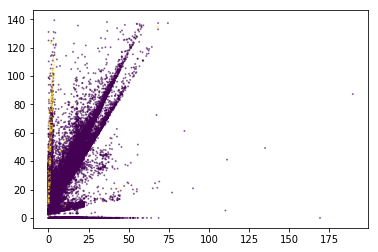

In [179]:
# Filter data based on on fare and trip miles, and mph, since we can't expect a future ride to exceed mph. It's illegal!
df_5['mph'] = df_5.trip_miles/df_5.trip_minutes * 60
df_6 = df_5.loc[(df_5.mph < 90) & (df_5.fare_dollars <= fare_upper) & (df_5.trip_miles <= distance_upper)]

# plot 
plt.scatter(df_6.trip_miles, df_6.fare_dollars, c = df_6.k2, s = 1, alpha = 0.5)
plt.show()

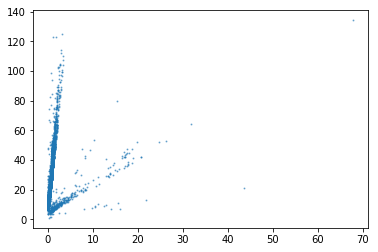

In [180]:
# plot the trip milesa and fare dollars based on the two groups
plt.scatter(df_6.trip_miles.loc[df_6.k2 == 1], df_6.fare_dollars.loc[df_6.k2 == 1], s = 1, alpha = 0.5)
plt.show()

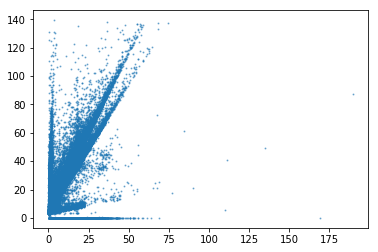

In [181]:
plt.scatter(df_6.trip_miles.loc[df_6.k2 == 0], df_6.fare_dollars.loc[df_6.k2 == 0], s = 1, alpha = 0.5)
plt.show()

#### k = 2 provides a good balance between complexity and explanatory purposes 

In [189]:
# training and testing
t = np.random.rand(df_train.shape[0]) < 0.8
traindf = df_train[t]
evaldf = df_train[~t]

traindf.to_csv('train.csv', index=False)
evaldf.to_csv('eval.csv', index=False)

In [190]:
!gsutil cp 'train.csv' 'gs://taxi_fare_3/data/csv/'
!gsutil cp 'eval.csv' 'gs://taxi_fare_3/data/csv/'


Copying file://train.csv [Content-Type=text/csv]...
-
Operation completed over 1 objects/31.1 MiB.                                     
Copying file://eval.csv [Content-Type=text/csv]...
/ [1 files][  7.8 MiB/  7.8 MiB]                                                
Operation completed over 1 objects/7.8 MiB.                                      


# Getting Test Data

In [182]:
# Pull Training Data
# The training data set will include 1M rows
# Feature engineering to generate new columns: 
#Year, Date, Hour, Weekday of the trip, whether the trip starts or end in an airport, duration of the trip in minutes.

sql = """
with tmp_tb as (
SELECT
    unique_key, 
    taxi_id, 
    DATETIME(trip_start_timestamp, 'America/Chicago') trip_start_timestamp, 
    DATETIME(trip_end_timestamp, 'America/Chicago') trip_end_timestamp, 
    trip_miles, 
    pickup_census_tract, 
    dropoff_census_tract, 
    pickup_community_area, 
    dropoff_community_area, 
    payment_type, 
    company, 
    pickup_latitude, 
    pickup_longitude, 
    dropoff_latitude, 
    dropoff_longitude,
    fare fare_dollars
FROM
    `bigquery-public-data.chicago_taxi_trips.taxi_trips` 
WHERE 
    fare > 0 and fare is not null and trip_miles > 0 and trip_miles is not null
ORDER BY 
    RAND()
LIMIT 100)
SELECT *, 
    CAST(trip_start_timestamp AS DATE) trip_start_dt,
    CAST(trip_end_timestamp AS DATE) trip_end_dt,
    DATETIME_DIFF(trip_end_timestamp, trip_start_timestamp, MINUTE) trip_minutes,
    EXTRACT(YEAR FROM trip_start_timestamp) year,
    EXTRACT(MONTH FROM trip_start_timestamp) month,
    EXTRACT(DAY FROM trip_start_timestamp) day,
    EXTRACT(HOUR FROM trip_start_timestamp) hour,
    FORMAT_DATE('%a', DATE(trip_start_timestamp)) weekday,
    CASE WHEN (pickup_community_area IN (56, 64, 76)) OR (dropoff_community_area IN (56, 64, 76)) THEN 1 else 0 END is_airport
FROM tmp_tb
"""

test = client.query(sql).to_dataframe()


In [183]:
# Merge with the driver's clusters
test_df2 = test.merge(by_driver, left_on = ['taxi_id'], right_on = ['taxi_id'], how = 'left')
# If a driver didn't exist in the training data set and hence no cluster, assign it to the popular group (most likely the normal taxi service group)
popular_k2 = by_driver.mode()['k2'][0]
test_df2.k2.fillna(popular_k2, inplace = True)
test_df2.k2 = test_df2.k2.astype(np.int64)

test_df2['is_luxury'] = np.where(test_df2.company.isin(['Blue Ribbon Taxi Association Inc.', 'Suburban Dispatch LLC']),1, 0)
test_df2['weekday2'] = test_df2.trip_start_timestamp.dt.dayofweek
test_df2['mph'] = test_df2.trip_miles/test_df2.trip_minutes * 60
test_df2['dollars_per_mile'] = test_df2.fare_dollars/test_df2.trip_miles

test_df2.head()

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,payment_type,...,total_fare,total_miles,miles_per_trip,dollars_per_mile,k2,k3,k4,is_luxury,weekday2,mph
0,4f0e2f2a968043b0ee1c329bf25fc4ccaa34be9b,bf94ef60fc5ff46add1644ac9f7b39dda81402cd865c46...,2018-08-14 15:15:00,2018-08-14 15:30:00,4.7,1.703184e+10,1.703106e+10,32.0,6.0,Credit Card,...,1913.35,656.60,4.155696,3.085106,0,0,2,0,1,18.8
1,5f26b4cdda70354da6b0b38f730e2dde4fcdf1a6,a0df6e84237fd11e0a52f45433e8067928dca5ce5ef04b...,2016-10-08 17:00:00,2016-10-08 17:15:00,0.1,1.703108e+10,1.703106e+10,8.0,6.0,Credit Card,...,811.20,66.02,0.956812,127.500000,0,0,0,0,5,0.4
2,2ed275bb8e31c98782606242e2b406046c62e1f2,63bd96dd48d993d6de99e296a9c9e425551d2481df12cf...,2016-08-03 16:45:00,2016-08-03 16:45:00,1.2,1.703108e+10,1.703108e+10,8.0,8.0,Cash,...,2565.80,962.50,5.904908,5.416667,0,0,2,0,2,inf
3,b6a209ce3af817d43d16767832fd264788a112a5,381b18e55254dd5635fefcf1b2a7956671bd47be71a38e...,2015-09-17 11:45:00,2015-09-17 12:00:00,1.6,1.703107e+10,1.703108e+10,7.0,8.0,Credit Card,...,3410.70,959.36,3.065048,4.281250,0,0,2,0,3,6.4
4,30bb5df76dcf8331c2c1793f082152495f134c0d,2ce840b44fa244ea47dfb86afff69589a13c283fa7b3ca...,2015-04-11 16:45:00,2015-04-11 16:45:00,0.8,1.703184e+10,1.703132e+10,32.0,32.0,Credit Card,...,2066.00,703.70,5.099275,6.062500,0,0,2,0,5,inf


# Model 1

In [184]:
include_columns_tf = ['hour', 
                      'weekday',
                      'pickup_latitude', 
                      'pickup_longitude',
                      'dropoff_latitude', 
                      'dropoff_longitude', 
                      'k2',
                      'is_luxury', 
                      'fare_dollars']

df_train = df_6[include_columns_tf].dropna(axis = 0, how = 'any')
df_train.shape

(588623, 9)

In [203]:
INPUT_COLUMNS = [
    tf.feature_column.numeric_column('hour'),
    tf.feature_column.categorical_column_with_hash_bucket('weekday', hash_bucket_size = 7),
    tf.feature_column.numeric_column('pickup_latitude'),
    tf.feature_column.numeric_column('pickup_longitude'),
    tf.feature_column.numeric_column('dropoff_latitude'),
    tf.feature_column.numeric_column('dropoff_longitude'),
    tf.feature_column.categorical_column_with_identity('k2', num_buckets = 2),
    tf.feature_column.categorical_column_with_identity('is_luxury', num_buckets = 2)
]

In [204]:
feature_columns={}
for i in INPUT_COLUMNS:
    feature_columns[i.key]=i
list(feature_columns.keys())

['pickup_longitude',
 'hour',
 'k2',
 'weekday',
 'dropoff_latitude',
 'pickup_latitude',
 'dropoff_longitude',
 'is_luxury']

In [205]:
# Build the estimator
# Reference: https://www.kaggle.com/markdavey/using-tensorflow-code-from-coursera-on-ml-gcp

def build_estimator(nbuckets, hidden_units):
    
    # Input columns 
    (hour, 
     dayofweek, 
     pickup_latitude, 
     pickup_longitude, 
     dropoff_latitude, 
     dropoff_longitude, 
     k2,
     is_luxury
    ) = INPUT_COLUMNS

    hourbuckets = np.linspace(0.0, 23.0, 24).tolist()
    buckets_hour = tf.feature_column.bucketized_column(hour, hourbuckets)    
    
    # bucket the longitude and latitude, based on the boundaries of Chicago
    latitude_buckets = np.linspace(41.6, 42.1, nbuckets).tolist()
    longitude_buckets = np.linspace(-88, -86, nbuckets).tolist()
    buckets_pickup_latitude = tf.feature_column.bucketized_column(pickup_latitude, latitude_buckets)
    buckets_dropoff_latitude = tf.feature_column.bucketized_column(dropoff_latitude, latitude_buckets)
    buckets_pickup_longitude = tf.feature_column.bucketized_column(pickup_longitude, longitude_buckets)
    buckets_dropoff_longitude = tf.feature_column.bucketized_column(dropoff_longitude, longitude_buckets)

    pickup = tf.feature_column.crossed_column([buckets_pickup_latitude, buckets_pickup_longitude], nbuckets * nbuckets)
    dropoff = tf.feature_column.crossed_column([buckets_dropoff_latitude, buckets_dropoff_longitude], nbuckets * nbuckets)
    loc_pair = tf.feature_column.crossed_column([pickup, dropoff], nbuckets ** 4 )
    
    wide_columns = [
        buckets_hour, dayofweek, k2, is_luxury
    ]

    deep_columns = [
        tf.feature_column.embedding_column(loc_pair, nbuckets),
        tf.feature_column.embedding_column(pickup, nbuckets),
        tf.feature_column.embedding_column(dropoff, nbuckets)
    ]
    
    estimator = tf.estimator.DNNLinearCombinedRegressor(
        linear_feature_columns = wide_columns,
        dnn_feature_columns = deep_columns,
        dnn_hidden_units = hidden_units)
      
    # Define Evaluation Metric: RMSE
    def rmse(labels, predictions):
        pred_values = tf.cast(predictions['predictions'],tf.float64)
        return {'rmse': tf.metrics.root_mean_squared_error(labels, pred_values)}
    
    estimator = tf.contrib.estimator.add_metrics(estimator, rmse)
    return estimator

In [206]:

nbuckets = 20
hidden_units = "128 32 4"
learning_rate = 0.000001
steps = 40000

train_input_fn = tf.estimator.inputs.pandas_input_fn(x = traindf[list(feature_columns.keys())],
                                                    y = traindf["fare_dollars"],
                                                    batch_size = 32,
                                                    shuffle = True)
eval_input_fn = tf.estimator.inputs.pandas_input_fn(x = evaldf[list(feature_columns.keys())],
                                                    y = evaldf["fare_dollars"], 
                                                    batch_size = evaldf.shape[0], 
                                                    shuffle = False)

In [105]:
def serving_input_fn(hyperparameters=None):
    feature_spec = {
        'pickup_latitude': tf.placeholder(dtype = tf.float32, shape=[None]),
        'hour': tf.placeholder(dtype = tf.float32, shape = [None]),
        'weekday': tf.placeholder(dtype = tf.string, shape = [None]),
        'pickup_longitude': tf.placeholder(dtype = tf.float32, shape = [None]),
        'dropoff_longitude': tf.placeholder(dtype = tf.float32, shape = [None]),
        'is_luxury': tf.placeholder(dtype = tf.int32, shape = [None]),
        'dropoff_latitude': tf.placeholder(dtype = tf.float32, shape = [None]),
        'k2': tf.placeholder(dtype = tf.int32, shape = [None])
      #  'trip_miles': tf.placeholder(dtype = tf.float32, shape = [None])
    }
    
    return tf.estimator.export.build_raw_serving_input_receiver_fn(feature_spec)
    

In [106]:
tf.logging.set_verbosity(tf.logging.INFO)
estimator = estimator = build_estimator(nbuckets, hidden_units.split(' '))

train_spec = tf.estimator.TrainSpec(input_fn = train_input_fn, max_steps = steps)
eval_spec = tf.estimator.EvalSpec(input_fn = eval_input_fn)

tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_summary_steps': 100, '_task_id': 0, '_keep_checkpoint_max': 5, '_save_checkpoints_steps': None, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_device_fn': None, '_evaluation_master': '', '_train_distribute': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd99064f908>, '_save_checkpoints_secs': 600, '_eval_distribute': None, '_protocol': None, '_is_chief': True, '_master': '', '_num_worker_replicas': 1, '_experimental_distribute': None, '_task_type': 'worker', '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_tf_random_seed': None, '_model_dir': '/tmp/tmp6ovn4am1', '_global_id_in_cluster': 0, '_num_ps_replicas': 0}
INFO:tensorflow:Using config: {'_save_summary_steps': 100, '_task_id': 0, '_keep_checkpoint_max': 5, '_save_checkpoints_steps': None, '_servi

({'average_loss': 27.674349,
  'global_step': 14587,
  'label/mean': 15.171458,
  'loss': 3235297.5,
  'prediction/mean': 15.177061,
  'rmse': 5.2606416},
 [])

In [107]:
estimator.export_savedmodel(export_dir_base='./Result_3/', 
                            serving_input_receiver_fn = serving_input_fn())

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Done calling model_fn.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['predict']
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Signatures EXCLUDED from export because they cannot be be served via TensorFlow Serving APIs:
INFO:tensorflow:'serving_default' : Regression input must be a single string Tensor; got {'k2': <tf.Tensor 'Placeholder_7:0' shape=(?,) dtype=int32>, 'dropoff_latitude': <tf.Tensor 'Placeholder_6:0' shape=(?,) dtype=float

b'./Result_3/1560109825'

In [112]:
!gsutil cp -r /home/jupyter/black-friday/Result_3/1560109825 gs://chicgo_fare_pred_tf_20190519

Copying file:///home/jupyter/black-friday/Result_3/1560109825/saved_model.pb [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/black-friday/Result_3/1560109825/variables/variables.index [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/black-friday/Result_3/1560109825/variables/variables.data-00000-of-00002 [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/black-friday/Result_3/1560109825/variables/variables.data-00001-of-00002 [Content-Type=application/octet-stream]...
- [4 files][ 12.8 MiB/ 12.8 MiB]                                                
Operation completed over 4 objects/12.8 MiB.                                     


# Model 1 Evaluation

In [108]:
predict_input_fn = tf.estimator.inputs.pandas_input_fn(x = test_df2[list(feature_columns.keys())],
                                                    y = None, 
                                                    batch_size = len(test_df2), 
                                                    shuffle=False)
predictions = estimator.predict(input_fn = predict_input_fn)

In [109]:
pred = pd.DataFrame({'fare_dollars':[i['predictions'][0] for i in predictions]})
test_df2['model1_pred'] = pred

rmse = sqrt(mean_squared_error(pred, test_df2.fare_dollars))
mae = mean_absolute_error(pred, test_df2.fare_dollars)

print ('The RMSE is', rmse, 'and the MAE is', mae, '.')

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp6ovn4am1/model.ckpt-14587
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
The RMSE is 39.991889707673955 and the MAE is 4.322017233769894 .


In [110]:
# Examine the test data for outliers/bad data
test_df2['model1_diff'] = test_df2.model1_pred - test_df2.fare_dollars
test_df2.sort_values(['model1_diff'], ascending = False).head()

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,payment_type,...,miles_per_trip,dollars_per_mile,k2,k3,k4,is_luxury,weekday2,mph,model1_pred,model1_diff
92543,4594dee9c2a5347cf42da523a5f1a91e89eaa539,c17582be31089967bcc79faa83fe8c0f7521a55e172fa8...,2013-02-25 00:45:00,2013-02-25 00:45:00,0.1,1.703198e+10,1.703198e+10,76.0,76.0,Cash,...,6.228942,22.500000,0,0.0,0.0,0,0,inf,39.544025,37.294025
1353,d7ee3c0dd9c440310e7554e8186b2e1736159e75,373a87b7084c01d24566ee3c5cfde562710dd94bd3cdfd...,2016-02-11 07:00:00,2016-02-11 07:00:00,0.3,1.703198e+10,1.703184e+10,76.0,32.0,Cash,...,7.748523,12.500000,0,0.0,0.0,0,3,inf,40.197868,36.447868
58635,35fd4ee608fbbe90e8cbe7e3a1ab765074ff6d51,6d0577e9fce3869a425a423ef6058feba996b49fccdcd2...,2015-09-30 11:00:00,2015-09-30 11:00:00,0.3,1.703198e+10,1.703198e+10,76.0,76.0,No Charge,...,3.330104,10.833333,0,0.0,0.0,0,2,inf,39.595890,36.345890
49993,419430d77b02555a220c494cc88518d0654cf9b8,ea9c7f865233f880e5f00abb728092901eeaf52c85a8c1...,2015-03-13 12:00:00,2015-03-13 12:00:00,2.5,1.703198e+10,1.703198e+10,76.0,76.0,Cash,...,5.235294,1.300000,0,0.0,0.0,0,4,inf,39.555866,36.305866
29437,a5db52d6626aab949fd958fd4da06ed96a72608e,29cfaf00459352d74acd44380b6f52f30b5f5586013fd4...,2013-10-31 01:15:00,2013-10-31 01:15:00,0.1,1.703198e+10,1.703198e+10,76.0,76.0,Cash,...,5.740984,32.500000,0,0.0,0.0,0,3,inf,39.545631,36.295631


#### In the testing dataset, there were some unrealistic data. For example, trip (601b40241df12809afc44ca989c9aa2c67dd8b81) traveled 1820 miles within 30 minutes. This would bias the evaluation. The next step is to clean the dataset with two criteria: mph < 90 and dollars per mils < 500. 

In [185]:
test_df2['mph'] = test_df2.trip_miles/test_df2.trip_minutes * 60
test_df2['dollars_per_mile'] = test_df2.fare_dollars/test_df2.trip_miles

# removing outliers
test_df3 = test_df2.loc[(test_df2.dollars_per_mile < 500) & (test_df2.mph < 90)]

rmse = sqrt(mean_squared_error(test_df3.model1_pred, test_df3.fare_dollars))
mae = mean_absolute_error(test_df3.model1_pred, test_df3.fare_dollars)

print ('The RMSE is', rmse, 'and the MAE is', mae, '.')

AttributeError: 'DataFrame' object has no attribute 'model1_pred'

In [198]:
#upload to GCP buket
test_df2['mph'] = test_df2.trip_miles/test_df2.trip_minutes * 60
test_df2['dollars_per_mile'] = test_df2.fare_dollars/test_df2.trip_miles

# removing outliers
test_df3 = test_df2.loc[(test_df2.dollars_per_mile < 500) & (test_df2.mph < 90)]

test_columns=['hour',
              'weekday',
              'pickup_latitude', 
              'pickup_longitude',
              'dropoff_latitude', 
              'dropoff_longitude', 
              'k2',
              'is_luxury']
test_df4 = test_df3[include_columns_tf]
test_df4.head()
test_df4.to_csv('test.csv', index=False, header=False)

In [200]:
test_df4.to_csv('test_wheaders.csv', index=False)

In [201]:
!gsutil cp 'test.csv' 'gs://taxi_fare_3/data/csv/'
!gsutil cp 'test_wheaders.csv' 'gs://taxi_fare_3/data/csv/'


Copying file://test.csv [Content-Type=text/csv]...
/ [1 files][  4.1 KiB/  4.1 KiB]                                                
Operation completed over 1 objects/4.1 KiB.                                      
Copying file://test_wheaders.csv [Content-Type=text/csv]...
/ [1 files][  4.2 KiB/  4.2 KiB]                                                
Operation completed over 1 objects/4.2 KiB.                                      


# Model 2

In [120]:
df_6['weekday2'] = df_6.trip_start_timestamp.dt.dayofweek

include_columns_xgboost = [
    'pickup_community_area', 
    'dropoff_community_area', 
    'is_airport', 
    'hour', 
    'weekday2', 
    'dollars_per_mile', 
    'is_luxury', 
    'k2']

x, y = df_6[include_columns_xgboost], df_6['fare_dollars']

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [121]:
params = {
    'min_child_weight': [1],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.5, 0.6],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [4, 5]
}

model = xgb.XGBRegressor()

grid = GridSearchCV(estimator = model, 
                    param_grid = params, 
                    scoring = 'neg_mean_squared_error',
                    cv = 3,
                    verbose = 3)

grid_results = grid.fit(x, y)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] gamma=0.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.6, score=-46.78112295723431, total=  26.7s
[CV] gamma=0.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.8s remaining:    0.0s
/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.6, score=-48.65937940551599, total=  26.6s
[CV] gamma=0.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.6 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   57.5s remaining:    0.0s
/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.6, score=-49.785532350783235, total=  26.7s
[CV] gamma=0.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.6, score=-46.88777929097398, total=  25.8s
[CV] gamma=0.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.6, score=-48.211378333204834, total=  26.3s
[CV] gamma=0.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.6, score=-49.595797502472784, total=  26.2s
[CV] gamma=0.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.6, score=-44.91339504743372, total=  32.6s
[CV] gamma=0.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.6, score=-46.02462452452643, total=  32.4s
[CV] gamma=0.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.6, score=-46.41858839658094, total=  32.3s
[CV] gamma=0.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.6, score=-44.714382282206934, total=  32.2s
[CV] gamma=0.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.6, score=-45.918126280393224, total=  31.8s
[CV] gamma=0.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.6, score=-46.98850294671405, total=  31.7s
[CV] gamma=1, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.6, score=-46.78112295723431, total=  27.1s
[CV] gamma=1, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.6, score=-48.65937940551599, total=  26.9s
[CV] gamma=1, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.6, score=-49.785532350783235, total=  26.8s
[CV] gamma=1, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.6, score=-46.88777929097398, total=  26.1s
[CV] gamma=1, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.6, score=-48.211378333204834, total=  26.2s
[CV] gamma=1, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.6, score=-49.595797502472784, total=  25.9s
[CV] gamma=1, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.6, score=-44.91339504743372, total=  32.1s
[CV] gamma=1, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.6, score=-46.02462487105942, total=  31.9s
[CV] gamma=1, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.6, score=-46.41858839658094, total=  32.2s
[CV] gamma=1, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.6, score=-44.714292590526625, total=  31.8s
[CV] gamma=1, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.6, score=-45.918126280393224, total=  31.8s
[CV] gamma=1, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.6, score=-46.98850294671405, total=  31.8s
[CV] gamma=1.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.6, score=-46.78112295723431, total=  26.7s
[CV] gamma=1.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.6, score=-48.65937940551599, total=  26.6s
[CV] gamma=1.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.6, score=-49.785532350783235, total=  26.8s
[CV] gamma=1.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.6, score=-46.88778646750727, total=  26.6s
[CV] gamma=1.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.6, score=-48.211378333204834, total=  26.1s
[CV] gamma=1.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.6, score=-49.595797502472784, total=  26.2s
[CV] gamma=1.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.6, score=-44.913430501618045, total=  32.6s
[CV] gamma=1.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.6, score=-46.02418257700728, total=  32.2s
[CV] gamma=1.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.6, score=-46.41858839658094, total=  32.5s
[CV] gamma=1.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.6, score=-44.71429780358765, total=  32.1s
[CV] gamma=1.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.6, score=-45.918126280393224, total=  32.2s
[CV] gamma=1.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.6, score=-46.98849847670748, total=  32.2s
[CV] gamma=2, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.6, score=-46.78112295723431, total=  27.2s
[CV] gamma=2, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.6, score=-48.65937940551599, total=  27.2s
[CV] gamma=2, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.6, score=-49.785532350783235, total=  27.0s
[CV] gamma=2, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.6, score=-46.88778646750727, total=  26.5s
[CV] gamma=2, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.6, score=-48.211378333204834, total=  26.5s
[CV] gamma=2, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.6, score=-49.595797502472784, total=  26.3s
[CV] gamma=2, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.6, score=-44.913430501618045, total=  32.4s
[CV] gamma=2, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.6, score=-46.02418257700728, total=  32.4s
[CV] gamma=2, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.6, score=-46.41858839658094, total=  32.7s
[CV] gamma=2, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.6, score=-44.714313910507215, total=  32.1s
[CV] gamma=2, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.6, score=-45.91813521870283, total=  31.8s
[CV] gamma=2, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.6, score=-46.98848010798834, total=  31.5s
[CV] gamma=5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.6, score=-46.78110757945866, total=  26.4s
[CV] gamma=5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.6, score=-48.65937940551599, total=  26.5s
[CV] gamma=5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.6, score=-49.785532350783235, total=  26.4s
[CV] gamma=5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.6, score=-46.88778646750727, total=  26.2s
[CV] gamma=5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.6, score=-48.211378333204834, total=  26.4s
[CV] gamma=5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.6, score=-49.595797502472784, total=  26.0s
[CV] gamma=5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.6, score=-44.91343146124891, total=  32.2s
[CV] gamma=5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.6, score=-45.99872474783056, total=  32.0s
[CV] gamma=5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.6, score=-46.41863165002719, total=  32.0s
[CV] gamma=5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.6, score=-44.71421946121788, total=  31.5s
[CV] gamma=5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.6, score=-45.918106303877394, total=  31.6s
[CV] gamma=5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.6 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.6, score=-46.98848550320536, total=  31.6s
[CV] gamma=0.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.8, score=-44.92345213115365, total=  31.8s
[CV] gamma=0.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.8, score=-45.091561473725235, total=  31.6s
[CV] gamma=0.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.8, score=-45.51550127359794, total=  31.8s
[CV] gamma=0.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.8, score=-45.012823084255935, total=  31.2s
[CV] gamma=0.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.8, score=-45.13771612258594, total=  31.1s
[CV] gamma=0.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.8, score=-45.406618909818576, total=  31.6s
[CV] gamma=0.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.8, score=-43.047797729434954, total=  39.6s
[CV] gamma=0.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.8, score=-43.27634434576238, total=  38.6s
[CV] gamma=0.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.8, score=-43.86143902270816, total=  39.1s
[CV] gamma=0.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.8, score=-43.165541086247046, total=  38.9s
[CV] gamma=0.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.8, score=-43.3167748725795, total=  38.8s
[CV] gamma=0.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.8, score=-43.83729270356579, total=  38.6s
[CV] gamma=1, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.8, score=-44.92345213115365, total=  31.7s
[CV] gamma=1, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.8, score=-45.091561473725235, total=  31.6s
[CV] gamma=1, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.8, score=-45.51550127359794, total=  31.8s
[CV] gamma=1, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.8, score=-45.012823084255935, total=  31.6s
[CV] gamma=1, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.8, score=-45.13771612258594, total=  31.3s
[CV] gamma=1, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.8, score=-45.406618909818576, total=  31.7s
[CV] gamma=1, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.8, score=-43.047797729434954, total=  39.7s
[CV] gamma=1, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.8, score=-43.27634434576238, total=  39.4s
[CV] gamma=1, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.8, score=-43.86143902270816, total=  39.2s
[CV] gamma=1, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.8, score=-43.165541086247046, total=  39.1s
[CV] gamma=1, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.8, score=-43.3167710261633, total=  38.6s
[CV] gamma=1, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.8, score=-43.83729270356579, total=  38.4s
[CV] gamma=1.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.8, score=-44.92345213115365, total=  31.7s
[CV] gamma=1.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.8, score=-45.091561473725235, total=  31.6s
[CV] gamma=1.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.8, score=-45.51550127359794, total=  31.9s
[CV] gamma=1.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.8, score=-45.012823084255935, total=  31.9s
[CV] gamma=1.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.8, score=-45.13771612258594, total=  31.4s
[CV] gamma=1.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.8, score=-45.406618909818576, total=  31.3s
[CV] gamma=1.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.8, score=-43.047797729434954, total=  39.2s
[CV] gamma=1.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.8, score=-43.276359780671534, total=  38.9s
[CV] gamma=1.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.8, score=-43.86143902270816, total=  40.1s
[CV] gamma=1.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.8, score=-43.16554191647853, total=  39.4s
[CV] gamma=1.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.8, score=-43.3167710261633, total=  39.3s
[CV] gamma=1.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.8, score=-43.83729270356579, total=  39.4s
[CV] gamma=2, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.8, score=-44.92345213115365, total=  32.1s
[CV] gamma=2, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.8, score=-45.091561473725235, total=  32.3s
[CV] gamma=2, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.8, score=-45.51550127359794, total=  32.6s
[CV] gamma=2, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.8, score=-45.012823084255935, total=  31.7s
[CV] gamma=2, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.8, score=-45.13771612258594, total=  31.5s
[CV] gamma=2, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.8, score=-45.40662236140851, total=  31.9s
[CV] gamma=2, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.8, score=-43.047797729434954, total=  39.8s
[CV] gamma=2, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.8, score=-43.276359780671534, total=  39.4s
[CV] gamma=2, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.8, score=-43.86143902270816, total=  39.5s
[CV] gamma=2, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.8, score=-43.16554191647853, total=  39.5s
[CV] gamma=2, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.8, score=-43.3167710261633, total=  39.2s
[CV] gamma=2, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.8, score=-43.837281304349965, total=  39.0s
[CV] gamma=5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.8, score=-44.92345213115365, total=  31.9s
[CV] gamma=5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.8, score=-44.9598140136249, total=  31.9s
[CV] gamma=5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=0.8, score=-45.51550127359794, total=  31.7s
[CV] gamma=5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.8, score=-45.012837293755155, total=  31.8s
[CV] gamma=5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.8, score=-45.13771612258594, total=  31.9s
[CV] gamma=5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=0.8, score=-45.40662236140851, total=  31.3s
[CV] gamma=5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.8, score=-43.04752010832573, total=  40.1s
[CV] gamma=5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.8, score=-43.27618526833882, total=  39.3s
[CV] gamma=5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=0.8, score=-43.86144193947263, total=  39.8s
[CV] gamma=5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.8, score=-43.16553965480471, total=  39.1s
[CV] gamma=5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.8, score=-43.31669521338314, total=  38.6s
[CV] gamma=5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.8 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=0.8, score=-43.837276700928996, total=  38.7s
[CV] gamma=0.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=1.0, score=-44.30480319529677, total=  37.2s
[CV] gamma=0.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=1.0, score=-44.66367509278644, total=  37.0s
[CV] gamma=0.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=1.0, score=-45.089689920482634, total=  36.9s
[CV] gamma=0.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=1.0, score=-44.616165082539844, total=  36.5s
[CV] gamma=0.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=1.0, score=-44.75453961935336, total=  36.5s
[CV] gamma=0.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=1.0, score=-45.005853430167306, total=  36.3s
[CV] gamma=0.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=1.0, score=-42.912253151821396, total=  46.1s
[CV] gamma=0.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=1.0, score=-42.933251244953446, total=  45.9s
[CV] gamma=0.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=1.0, score=-43.70870700365908, total=  46.5s
[CV] gamma=0.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=1.0, score=-43.079056067108525, total=  45.9s
[CV] gamma=0.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=1.0, score=-42.89935751880656, total=  46.2s
[CV] gamma=0.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=0.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=1.0, score=-43.67687345869277, total=  45.8s
[CV] gamma=1, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=1.0, score=-44.30480319529677, total=  37.0s
[CV] gamma=1, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=1.0, score=-44.66367509278644, total=  37.1s
[CV] gamma=1, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=1.0, score=-45.089689920482634, total=  37.1s
[CV] gamma=1, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=1.0, score=-44.616165082539844, total=  36.5s
[CV] gamma=1, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=1.0, score=-44.75453961935336, total=  36.5s
[CV] gamma=1, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=1.0, score=-45.005853430167306, total=  36.5s
[CV] gamma=1, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=1.0, score=-42.912253151821396, total=  46.7s
[CV] gamma=1, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=1.0, score=-42.93324874668004, total=  46.6s
[CV] gamma=1, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=1.0, score=-43.70870700365908, total=  46.4s
[CV] gamma=1, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=1.0, score=-43.079056067108525, total=  46.2s
[CV] gamma=1, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=1.0, score=-42.899066274445204, total=  46.1s
[CV] gamma=1, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=1.0, score=-43.67687345869277, total=  45.6s
[CV] gamma=1.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=1.0, score=-44.30480319529677, total=  37.2s
[CV] gamma=1.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=1.0, score=-44.66367509278644, total=  36.8s
[CV] gamma=1.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=1.0, score=-45.089689920482634, total=  36.6s
[CV] gamma=1.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=1.0, score=-44.61615077665244, total=  36.6s
[CV] gamma=1.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=1.0, score=-44.75453961935336, total=  36.3s
[CV] gamma=1.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=1.0, score=-45.005853430167306, total=  36.1s
[CV] gamma=1.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=1.0, score=-42.912253151821396, total=  46.4s
[CV] gamma=1.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=1.0, score=-42.93324874668004, total=  45.9s
[CV] gamma=1.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=1.0, score=-43.708701764725376, total=  46.1s
[CV] gamma=1.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=1.0, score=-43.079056067108525, total=  45.5s
[CV] gamma=1.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=1.0, score=-42.899066274445204, total=  45.4s
[CV] gamma=1.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=1.5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=1.0, score=-43.67687345869277, total=  46.8s
[CV] gamma=2, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=1.0, score=-44.30480319529677, total=  37.3s
[CV] gamma=2, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=1.0, score=-44.66367509278644, total=  36.9s
[CV] gamma=2, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=1.0, score=-45.089689920482634, total=  36.6s
[CV] gamma=2, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=1.0, score=-44.61615077665244, total=  36.2s
[CV] gamma=2, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=1.0, score=-44.75453961935336, total=  36.2s
[CV] gamma=2, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=1.0, score=-45.005853430167306, total=  36.0s
[CV] gamma=2, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=1.0, score=-42.912253151821396, total=  46.9s
[CV] gamma=2, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=1.0, score=-42.93324874668004, total=  46.7s
[CV] gamma=2, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=1.0, score=-43.708701764725376, total=  45.8s
[CV] gamma=2, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=1.0, score=-43.079056067108525, total=  46.0s
[CV] gamma=2, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=1.0, score=-42.899066274445204, total=  45.5s
[CV] gamma=2, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=2, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=1.0, score=-43.67687345869277, total=  45.1s
[CV] gamma=5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=1.0, score=-44.30480319529677, total=  36.9s
[CV] gamma=5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=1.0, score=-44.66367509278644, total=  37.1s
[CV] gamma=5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.5, max_depth=4, min_child_weight=1, colsample_bytree=1.0, score=-45.089689920482634, total=  36.8s
[CV] gamma=5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=1.0, score=-44.61615077665244, total=  36.6s
[CV] gamma=5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=1.0, score=-44.75453961935336, total=  36.5s
[CV] gamma=5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.6, max_depth=4, min_child_weight=1, colsample_bytree=1.0, score=-45.005853430167306, total=  35.9s
[CV] gamma=5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=1.0, score=-42.912335479164256, total=  46.4s
[CV] gamma=5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=1.0, score=-42.93324874668004, total=  46.4s
[CV] gamma=5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.5, max_depth=5, min_child_weight=1, colsample_bytree=1.0, score=-43.708701764725376, total=  47.0s
[CV] gamma=5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=1.0, score=-43.079085712736635, total=  46.4s
[CV] gamma=5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=1.0, score=-42.899066274445204, total=  45.1s
[CV] gamma=5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=1.0 


/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  gamma=5, subsample=0.6, max_depth=5, min_child_weight=1, colsample_bytree=1.0, score=-43.67687345869277, total=  45.8s


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 113.2min finished
/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [124]:
results = pd.DataFrame(grid_results.cv_results_)
results.to_csv('chicago_taxi_fare_pred_grid_search_results_2.csv')

In [148]:
model_filename = 'xgb_model_v2.bst'
grid_results.best_estimator_.save_model(model_filename)

%env BUCKET_ID chicago_fare_pred_xgb_20190529
!gsutil cp ./xgb_model_v2.bst gs://$BUCKET_ID/model.bst

env: BUCKET_ID=chicago_fare_pred_xgb_20190529
Copying file://./xgb_model_v2.bst [Content-Type=application/octet-stream]...
/ [1 files][233.4 KiB/233.4 KiB]                                                
Operation completed over 1 objects/233.4 KiB.                                    


# Model 2 Evaluation

In [126]:
include_columns_xgboost = [
    'pickup_community_area', 
    'dropoff_community_area', 
    'is_airport', 
    'hour', 
    'weekday2', 
    'dollars_per_mile', 
    'is_luxury', 
    'k2']
x_test = test_df2[include_columns_xgboost]
y_pred = grid_results.best_estimator_.predict(x_test)
test_df2['model2_pred'] = y_pred
test_df2.to_csv('chicago_taxi_fare_pred_test.csv')

In [127]:
rmse = sqrt(mean_squared_error(test_df2.model2_pred, test_df2.fare_dollars))
mae = mean_absolute_error(test_df2.model2_pred, test_df2.fare_dollars)
print ('The RMSE is', rmse, 'and the MAE is', mae, '.')

The RMSE is 39.823562275129696 and the MAE is 4.179451252179336 .


In [128]:
# removing outliers
test_df3 = test_df2.loc[(test_df2.dollars_per_mile < 500) & (test_df2.mph < 90)]

rmse = sqrt(mean_squared_error(test_df3.model2_pred, test_df3.fare_dollars))
mae = mean_absolute_error(test_df3.model2_pred, test_df3.fare_dollars)

print ('The RMSE is', rmse, 'and the MAE is', mae, '.')

The RMSE is 7.471342423811237 and the MAE is 3.909255358614245 .


# Online Predictions

## Model 1

In [113]:
# Reference: https://cloud.google.com/ml-engine/docs/tensorflow/online-predict

def predict_json(project, model, instances, version=None):
    service = googleapiclient.discovery.build('ml', 'v1')
    name = 'projects/{}/models/{}'.format(project, model)

    if version is not None:
        name += '/versions/{}'.format(version)

    response = service.projects().predict(
        name=name,
        body={'instances': instances}
    ).execute()

    if 'error' in response:
        raise RuntimeError(response['error'])

    return response['predictions']

In [118]:
tf_test_input = [{'dropoff_latitude': 41.892072635, 
                                'dropoff_longitude': -87.626210532, 
                                'hour': 12, 
                                'is_luxury': 0, 
                                'k2': 0, 
                                'pickup_latitude': 41.97907082, 
                                'pickup_longitude': -87.903039661, 
                                'weekday': 'Wed'}
                              ]
tf_test_input

[{'dropoff_latitude': 41.892072635,
  'dropoff_longitude': -87.626210532,
  'hour': 12,
  'is_luxury': 0,
  'k2': 0,
  'pickup_latitude': 41.97907082,
  'pickup_longitude': -87.903039661,
  'weekday': 'Wed'}]

In [119]:
import googleapiclient.discovery

PROJECT_ID = 'hackathon1-183523'
VERSION_NAME = 'v2'
MODEL_NAME = 'chicago_fare_pred_tf_20190519'

predict_json(PROJECT_ID, MODEL_NAME, tf_test_input, version = VERSION_NAME)

[{'predictions': [38.50304412841797]}]

## Model 2

In [134]:
include_columns_xgboost = [
    'pickup_community_area', 
    'dropoff_community_area', 
    'is_airport', 
    'hour', 
    'weekday2', 
    'dollars_per_mile', 
    'is_luxury', 
    'k2']
online_pred_input_xgboost = test_df2.loc[(test_df2.dollars_per_mile < 500) & (test_df2.mph < 90)]

online_pred_input_xgboost = online_pred_input_xgboost[include_columns_xgboost]
online_pred_input_xgboost.head() 

,pickup_community_area,dropoff_community_area,is_airport,hour,weekday2,dollars_per_mile,is_luxury,k2
0,33.0,28.0,0,7,2,3.732143,0,0
2,8.0,32.0,0,8,2,4.906250,0,0
3,32.0,24.0,0,14,3,3.660714,0,0
7,8.0,32.0,0,13,4,4.250000,0,0
8,8.0,8.0,0,19,6,5.333333,0,0


In [160]:
import googleapiclient.discovery
import time

gcp_pred_data = online_pred_input_xgboost[1:1000]
data = gcp_pred_data.values.tolist()

PROJECT_ID = 'hackathon1-183523'
VERSION_NAME = 'v3'
MODEL_NAME = 'chicago_fare_pred_xgboost_v1'

service = googleapiclient.discovery.build('ml', 'v1')
name = 'projects/{}/models/{}'.format(PROJECT_ID, MODEL_NAME)
name += '/versions/{}'.format(VERSION_NAME)

response = service.projects().predict(
    name = name,
    body = {'instances': data}
).execute()

if 'error' in response:
    print (response['error'])
else:
    online_results = response['predictions']

In [162]:
online_results[1:5]

[10.852655410766602, 8.263307571411133, 7.572323322296143, 7.650976181030273]